<a href="https://colab.research.google.com/github/gongbububu/gongbububu/blob/main/%EC%A0%84%EA%B7%B9%EA%B5%AC%EC%A1%B0%EB%AA%A8%EC%82%AC_CMK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LFP 배치 위치: (7.12, 2.87), 반지름: 1.94, 기공률: 88.19%
LFP 배치 위치: (9.01, 9.04), 반지름: 1.89, 기공률: 76.43%
LFP 배치 위치: (2.01, 0.42), 반지름: 1.41, 기공률: 69.90%
LFP 배치 위치: (0.20, 4.56), 반지름: 1.80, 기공률: 59.20%
LFP 배치 위치: (3.86, 9.45), 반지름: 1.53, 기공률: 51.50%
LFP 배치 위치: (0.75, 9.69), 반지름: 1.32, 기공률: 45.74%
LFP 배치 위치: (3.61, 4.90), 반지름: 1.36, 기공률: 39.97%
LFP 배치 위치: (9.42, 5.71), 반지름: 1.27, 기공률: 34.65%
LFP 배치 위치: (8.98, -0.09), 반지름: 1.32, 기공률: 28.87%
LFP 배치 위치: (5.63, 6.79), 반지름: 1.27, 기공률: 23.77%
LFP 배치 위치: (5.19, 0.01), 반지름: 1.34, 기공률: 17.84%
Final porosity: 17.84%


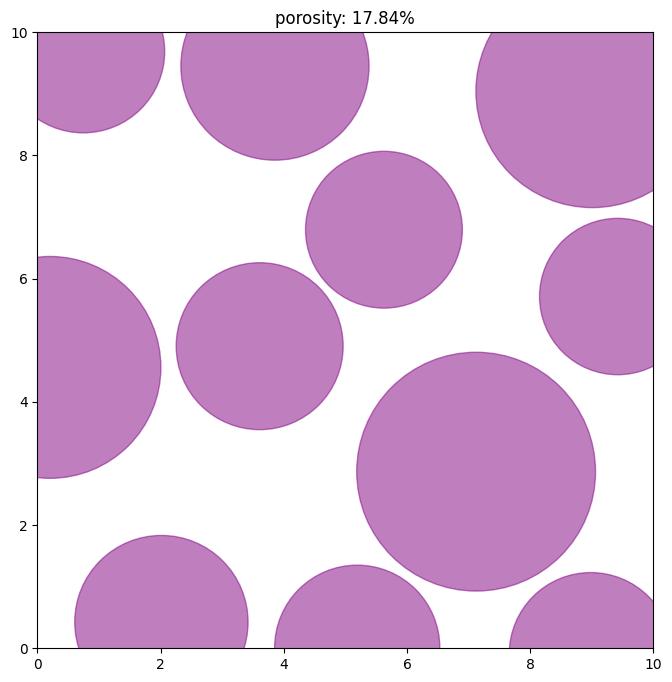

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi

# 랜덤 시드 고정
np.random.seed(3)

# 원의 면적 계산 함수 (잘린 원을 포함한 계산)
def circle_rect_area(x, y, r, domain_size):
    if 0 <= x - r and x + r <= domain_size and 0 <= y - r and y + r <= domain_size:
        return pi * r**2
    else:
        return pi * r**2 * 1.05

# LFP 배치 함수
def increase_radius_to_target_porosity(domain_size, min_r_LFP=1.25, max_r_LFP=2.5, target_porosity=0.2, max_attempts=10000):
    lfp_positions = []
    total_area = domain_size ** 2
    max_occupied_area = total_area * (1 - target_porosity)
    occupied_area = 0
    attempts = 0

    while occupied_area < max_occupied_area and attempts < max_attempts:
        r_LFP = np.random.uniform(min_r_LFP, max_r_LFP)
        x = np.random.uniform(-0.1, domain_size + 0.1)
        y = np.random.uniform(-0.1, domain_size + 0.1)

        overlap = False
        for lx, ly, lr in lfp_positions:
            dist = np.hypot(x - lx, y - ly)
            if dist < (r_LFP + lr) * 1.05:
                overlap = True
                break

        if not overlap:
            lfp_positions.append((x, y, r_LFP))
            occupied_area = sum(circle_rect_area(x, y, r, domain_size) for (x, y, r) in lfp_positions)
            print(f"LFP 배치 위치: ({x:.2f}, {y:.2f}), 반지름: {r_LFP:.2f}, 기공률: {1 - occupied_area / total_area:.2%}")

        attempts += 1

    while occupied_area < max_occupied_area and attempts < max_attempts:
        lfp_positions.sort(key=lambda x: x[2])

        for i in range(len(lfp_positions)):
            lx, ly, lr = lfp_positions[i]
            if lr < max_r_LFP:
                new_lr = lr + 0.07
                overlap = False
                for j in range(len(lfp_positions)):
                    if i != j:
                        lpx, lpy, lpr = lfp_positions[j]
                        dist = np.hypot(lx - lpx, ly - lpy)
                        if dist < (new_lr + lpr) * 1.05:
                            overlap = True
                            break

                if not overlap:
                    lfp_positions[i] = (lx, ly, new_lr)
                    occupied_area = sum(circle_rect_area(x, y, r, domain_size) for (x, y, r) in lfp_positions)
                    print(f"LFP 배치 위치: ({lx:.2f}, {ly:.2f}), 반지름: {new_lr:.2f}, 기공률: {1 - occupied_area / total_area:.2%}")

        attempts += 1

    occupied_area = sum(circle_rect_area(x, y, r_LFP, domain_size) for (x, y, r_LFP) in lfp_positions)
    porosity = 1 - occupied_area / total_area
    print(f"Final porosity: {porosity:.2%}")

    return lfp_positions

# 예시 사용
domain_size = 10
target_porosity = 0.1
lfp_positions = increase_radius_to_target_porosity(domain_size, target_porosity=target_porosity)

# 시각화
plt.figure(figsize=(8, 8))
for (lx, ly, lr) in lfp_positions:
    circle = patches.Circle((lx, ly), lr, color='purple', alpha=0.5)
    plt.gca().add_artist(circle)
plt.xlim(0, domain_size)
plt.ylim(0, domain_size)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"porosity: {1 - sum(circle_rect_area(x, y, r_LFP, domain_size) for (x, y, r_LFP) in lfp_positions) / (domain_size ** 2):.2%}")
plt.show()


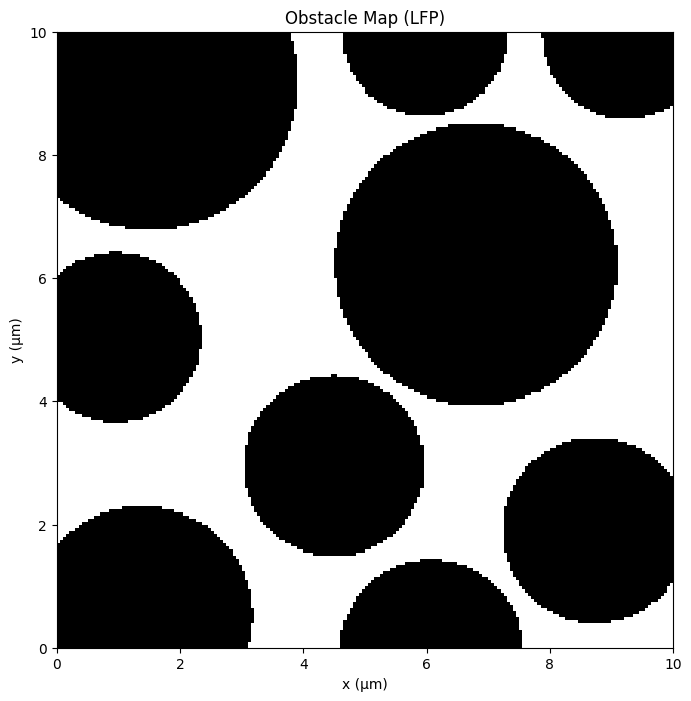

In [ ]:
 def generate_obstacle_map(domain_size, grid_size, lfp_positions, r_cb=0.1):
    grid_resolution = int(domain_size / grid_size)
    obstacle_map = np.zeros((grid_resolution, grid_resolution), dtype=int)

    def mark_obstacle(cx, cy, r):
        for i in range(grid_resolution):
            for j in range(grid_resolution):
                x = i * grid_size + grid_size / 2
                y = j * grid_size + grid_size / 2
                if np.hypot(cx - x, cy - y) <= r:
                    obstacle_map[i, j] = 1

    for lx, ly, lr in lfp_positions:
        mark_obstacle(lx, ly, lr)


    return obstacle_map

# 예시 사용
grid_size = 0.05
obstacle_map = generate_obstacle_map(domain_size, grid_size, lfp_positions)

plt.figure(figsize=(8, 8))
plt.imshow(obstacle_map.T, origin='lower', cmap='Greys', extent=[0, domain_size, 0, domain_size])
plt.title("Obstacle Map (LFP)")
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")
plt.grid(False)
plt.show()

LFP 배치 위치: (7.12, 2.87), 반지름: 1.94, 기공률: 88.19%
LFP 배치 위치: (9.01, 9.04), 반지름: 1.89, 기공률: 76.43%
LFP 배치 위치: (2.01, 0.42), 반지름: 1.41, 기공률: 69.90%
LFP 배치 위치: (0.20, 4.56), 반지름: 1.80, 기공률: 59.20%
LFP 배치 위치: (3.86, 9.45), 반지름: 1.53, 기공률: 51.50%
LFP 배치 위치: (0.75, 9.69), 반지름: 1.32, 기공률: 45.74%
LFP 배치 위치: (3.61, 4.90), 반지름: 1.36, 기공률: 39.97%
LFP 배치 위치: (9.42, 5.71), 반지름: 1.27, 기공률: 34.65%
LFP 배치 위치: (8.98, -0.09), 반지름: 1.32, 기공률: 28.87%
LFP 배치 위치: (5.63, 6.79), 반지름: 1.27, 기공률: 23.77%
LFP 배치 위치: (5.19, 0.01), 반지름: 1.34, 기공률: 17.84%
Final porosity: 17.84%
가장 큰 빈 직사각형(픽셀 기준): (np.int64(127), 0, np.int64(31), 87)
실제 좌표(μm): x=0.00, y=6.35, width=4.35, height=1.55


<ipython-input-24-09cd1c5886b1>:167: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-09cd1c5886b1>:167: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-09cd1c5886b1>:167: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-09cd1c5886b1>:167: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-09cd1c5886b1>:167: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-09cd1c5886b1>:167: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-09cd1c5886b1>:167: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout

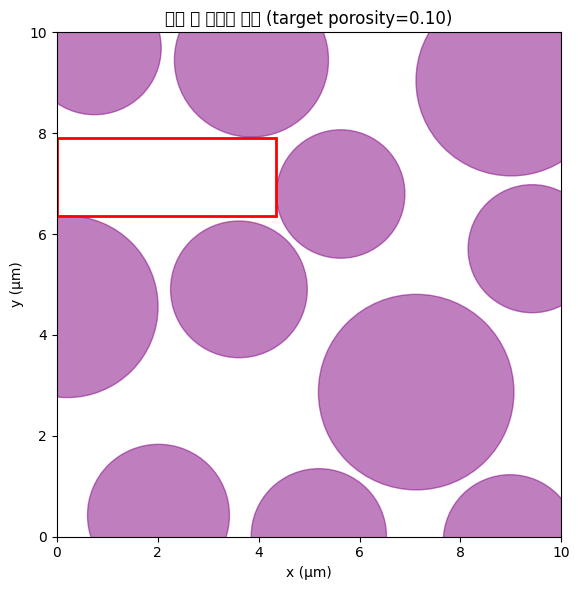

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi

# ---------------------------------------------------------------
# 1) 원의 면적 계산 함수 (잘린 원 보정 포함)
# ---------------------------------------------------------------
def circle_rect_area(x, y, r, domain_size):
    """
    (x,y) 중심, r 반지름인 원이 domain_size×domain_size 내에
    완전히 들어가면 pi*r^2,
    일부가 나가면 약간 보정하여 pi*r^2*1.05 리턴.
    """
    if 0 <= x - r and x + r <= domain_size and 0 <= y - r and y + r <= domain_size:
        return pi * r**2
    else:
        return pi * r**2 * 1.05




# ---------------------------------------------------------------
# 3) 히스토그램 기반 “최대 빈 직사각형 찾기” 알고리즘
#    (각 행마다 ‘빈 공간 연속 높이’를 히스토그램으로 보고,
#     largest rectangle in histogram 알고리즘 적용)
# ---------------------------------------------------------------
def find_largest_empty_rectangle(binary_map):
    """
    binary_map: 2차원 NumPy 배열 (0=빈 공간, 1=장애물).
    각 행마다 “이전 행까지 쌓인 연속된 0의 개수”를 히스토그램 높이로 보고,
    O(N*M) 시간에 “binary_map 전체에서 가장 넓은 0 직사각형”을 찾습니다.

    반환값:
       (best_row, best_col, best_height, best_width)
       → “가장 큰 직사각형”의 왼쪽 아래 꼭짓점이 (best_row, best_col)이고,
          height=best_height, width=best_width 인 픽셀 단위 정보.
    """
    H, W = binary_map.shape

    # 각 열마다 “지금까지 이어진 연속된 0의 높이”를 저장할 배열
    heights = np.zeros(W, dtype=int)
    best_area = 0
    best_params = (0, 0, 0, 0)  # (행, 열, 높이, 너비)

    for i in range(H):
        # 1) heights 배열 갱신:
        #    binary_map[i,j] == 0 이면 heights[j] += 1, 아니면 0 리셋.
        for j in range(W):
            if binary_map[i, j] == 0:
                heights[j] += 1
            else:
                heights[j] = 0

        # 2) 이 “heights”를 히스토그램으로 보고,
        #    largest rectangle in histogram 알고리즘 수행
        stack = []
        for j in range(W + 1):
            # sentinel: j==W 일 때, height=0 로 가정
            h = heights[j] if j < W else 0
            # 스택이 비지 않았고, 현재 높이<h_top 이면 pop 처리
            while stack and (heights[stack[-1]] > h):
                top = stack.pop()
                height_top = heights[top]
                # 넓이 계산:
                #   right boundary = j - 1,
                #   left boundary  = (stack[-1] + 1) if stack 남아있으면, else 0
                if stack:
                    width_rect = j - stack[-1] - 1
                    col_start = stack[-1] + 1
                else:
                    width_rect = j
                    col_start = 0
                area = height_top * width_rect
                if area > best_area:
                    best_area = area
                    # i 행까지 히스토그램을 본 것이므로, 사각형의 “아래쪽 행”은 (i - height_top + 1)
                    row_start = i - height_top + 1
                    best_params = (row_start, col_start, height_top, width_rect)
            stack.append(j)

    return best_params  # (row_start, col_start, height, width) 픽셀 기준


# ---------------------------------------------------------------
# 4) 메인: 원 배치 후, 격자화 → 빈 사각형 탐색 → 시각화
# ---------------------------------------------------------------
if __name__ == "__main__":
    # (4-1)  LFP(원) 배치 파라미터
    domain_size = 10              # 도메인: 0~10 μm
    target_porosity = 0.1         # 목표 기공률 10%
    np.random.seed(3)

    # (4-2)  원 배치 함수 호출 → (x,y,r) 리스트 얻기
    lfp_positions = increase_radius_to_target_porosity(
        domain_size=domain_size,
        min_r_LFP=1.25,
        max_r_LFP=2.5,
        target_porosity=target_porosity,
        max_attempts=10000
    )

    # (4-3) “격자 해상도” 설정 (예: 200×200 픽셀)
    grid_size = 200
    H = W = grid_size

    # (4-4) 장애물 맵 생성: 도메인 내 각 픽셀(격자) 중심이
    #       원 안쪽에 속하면 1, 아니면 0.
    obstacle_map = np.zeros((H, W), dtype=np.uint8)
    # 픽셀 하나의 물리적 크기
    dx = domain_size / W
    dy = domain_size / H

    for i in range(H):
        for j in range(W):
            # 이 격자의 중심 좌표(μm 단위)
            x_center = (j + 0.5) * dx
            y_center = (i + 0.5) * dy

            # 모든 원들 중 하나라도 이 점을 포함하면 장애물=1
            for (cx, cy, cr) in lfp_positions:
                if (x_center - cx)**2 + (y_center - cy)**2 <= cr**2:
                    obstacle_map[i, j] = 1
                    break

    # (4-5) obstacle_map 에서 빈 직사각형(0) 중 최대 크기 탐색
    row0, col0, height_pix, width_pix = find_largest_empty_rectangle(obstacle_map)
    # row0, col0 = 사각형의 “왼쪽 아래 꼭짓점”(픽셀 인덱스)
    # height_pix, width_pix = 픽셀 단위 높이/너비

    # (4-6) 픽셀 단위 결과 → 실제 도메인 좌표(μm)로 변환
    x_rect = col0 * dx                     # 사각형 왼쪽 아래 x
    y_rect = row0 * dy                     # 사각형 왼쪽 아래 y
    w_rect = width_pix * dx                # 사각형 너비 (μm)
    h_rect = height_pix * dy               # 사각형 높이(μm)

    print("가장 큰 빈 직사각형(픽셀 기준):", (row0, col0, height_pix, width_pix))
    print(f"실제 좌표(μm): x={x_rect:.2f}, y={y_rect:.2f}, width={w_rect:.2f}, height={h_rect:.2f}")

    # (4-7) 시각화: 원 + 최대 빈 직사각형
    fig, ax = plt.subplots(figsize=(6, 6))

    # • 원( LFP ) 그리기 (보라색, 반투명)
    for (cx, cy, cr) in lfp_positions:
        circ = patches.Circle((cx, cy), cr, color='purple', alpha=0.5)
        ax.add_patch(circ)

    # • 최대 빈 직사각형 그리기 (빨간 테두리, 면색 투명)
    rect = patches.Rectangle(
        (x_rect, y_rect),
        w_rect,
        h_rect,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

    # • 도메인 축 설정
    ax.set_xlim(0, domain_size)
    ax.set_ylim(0, domain_size)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
    ax.set_title(f"최대 빈 사각형 표시 (target porosity={target_porosity:.2f})")

    plt.tight_layout()
    plt.show()


LFP 배치 위치: (7.12, 2.87), 반지름: 1.94, 기공률: 88.19%
LFP 배치 위치: (9.01, 9.04), 반지름: 1.89, 기공률: 76.43%
LFP 배치 위치: (2.01, 0.42), 반지름: 1.41, 기공률: 69.90%
LFP 배치 위치: (0.20, 4.56), 반지름: 1.80, 기공률: 59.20%
LFP 배치 위치: (3.86, 9.45), 반지름: 1.53, 기공률: 51.50%
LFP 배치 위치: (0.75, 9.69), 반지름: 1.32, 기공률: 45.74%
LFP 배치 위치: (3.61, 4.90), 반지름: 1.36, 기공률: 39.97%
LFP 배치 위치: (9.42, 5.71), 반지름: 1.27, 기공률: 34.65%
LFP 배치 위치: (8.98, -0.09), 반지름: 1.32, 기공률: 28.87%
LFP 배치 위치: (5.63, 6.79), 반지름: 1.27, 기공률: 23.77%
LFP 배치 위치: (5.19, 0.01), 반지름: 1.34, 기공률: 17.84%
Final porosity: 17.84%
찾은 빈 직사각형 1 (픽셀 기준): (np.int64(127), 0, np.int64(31), 87)
실제 좌표(μm): x=0.00, y=6.35, width=4.35, height=1.55
찾은 빈 직사각형 2 (픽셀 기준): (np.int64(37), 34, np.int64(34), 70)
실제 좌표(μm): x=1.70, y=1.85, width=3.50, height=1.70
찾은 빈 직사각형 3 (픽셀 기준): (np.int64(161), 108, np.int64(39), 34)
실제 좌표(μm): x=5.40, y=8.05, width=1.70, height=1.95


<ipython-input-33-e0eff8b7c1f5>:113: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-33-e0eff8b7c1f5>:113: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-33-e0eff8b7c1f5>:113: UserWarning: Glyph 53360 (\N{HANGUL SYLLABLE KEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-33-e0eff8b7c1f5>:113: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-33-e0eff8b7c1f5>:113: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-33-e0eff8b7c1f5>:113: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-33-e0eff8b7c1f5>:113: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layou

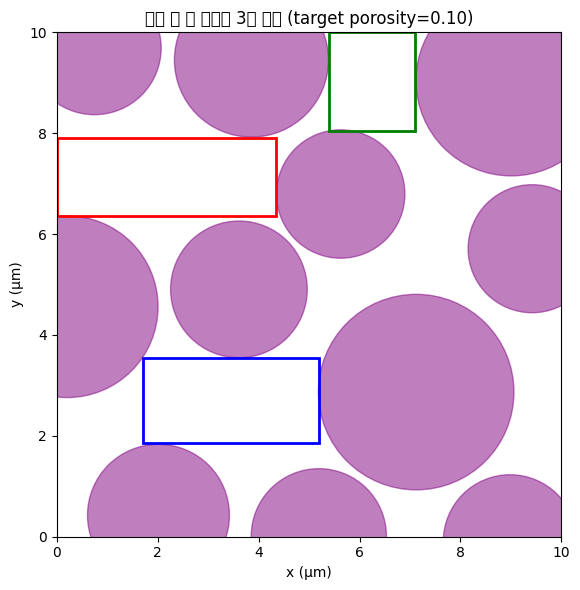

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi

# 이전에 정의된 circle_rect_area 및 find_largest_empty_rectangle 함수는 여기에 포함되었다고 가정합니다.
# (사용자의 이전 코드를 그대로 사용하시면 됩니다.)
# ... (circle_rect_area 함수 정의) ...
# ... (find_largest_empty_rectangle 함수 정의) ...


# ---------------------------------------------------------------
# 4) 메인: 원 배치 후, 격자화 → 빈 사각형 탐색 → 시각화 (2개 추가)
# ---------------------------------------------------------------
if __name__ == "__main__":
    # (4-1)  LFP(원) 배치 파라미터
    domain_size = 10              # 도메인: 0~10 μm
    target_porosity = 0.1         # 목표 기공률 10%
    np.random.seed(3)

    # (4-2)  원 배치 함수 호출 → (x,y,r) 리스트 얻기
    # increase_radius_to_target_porosity 함수도 이전 셀에 정의되었다고 가정합니다.
    lfp_positions = increase_radius_to_target_porosity(
        domain_size=domain_size,
        min_r_LFP=1.25,
        max_r_LFP=2.5,
        target_porosity=target_porosity,
        max_attempts=10000
    )

    # (4-3) “격자 해상도” 설정 (예: 200×200 픽셀)
    grid_size = 200
    H = W = grid_size

    # (4-4) 장애물 맵 생성: 도메인 내 각 픽셀(격자) 중심이
    #       원 안쪽에 속하면 1, 아니면 0.
    # find_largest_empty_rectangle 함수가 이 맵을 수정하지 않도록 복사본을 사용합니다.
    initial_obstacle_map = np.zeros((H, W), dtype=np.uint8)
    dx = domain_size / W
    dy = domain_size / H

    for i in range(H):
        for j in range(W):
            x_center = (j + 0.5) * dx
            y_center = (i + 0.5) * dy

            for (cx, cy, cr) in lfp_positions:
                if (x_center - cx)**2 + (y_center - cy)**2 <= cr**2:
                    initial_obstacle_map[i, j] = 1
                    break

    # (4-5) 가장 큰 빈 직사각형 3개 찾기
    found_rectangles_pix = []
    current_obstacle_map = initial_obstacle_map.copy() # 맵 복사하여 사용

    for k in range(3): # 가장 큰 사각형 3개 찾기
        row0, col0, height_pix, width_pix = find_largest_empty_rectangle(current_obstacle_map)

        # 찾은 사각형이 유효한 크기인지 확인 (예: 최소 1x1 픽셀)
        if width_pix > 0 and height_pix > 0:
            found_rectangles_pix.append((row0, col0, height_pix, width_pix))

            # 찾은 사각형 영역을 임시로 장애물로 표시하여 다음 탐색에서 제외
            # (이 부분을 1로 채우면 다음번 find_largest_empty_rectangle 호출 시 이 영역은 빈 공간으로 간주되지 않습니다)
            current_obstacle_map[row0 : row0 + height_pix, col0 : col0 + width_pix] = 1
        else:
            # 더 이상 유효한 크기의 빈 사각형이 없으면 중단
            break

    # (4-6) 픽셀 단위 결과 → 실제 도메인 좌표(μm)로 변환
    found_rectangles_mu = []
    for (row0, col0, height_pix, width_pix) in found_rectangles_pix:
        x_rect = col0 * dx
        y_rect = row0 * dy
        w_rect = width_pix * dx
        h_rect = height_pix * dy
        found_rectangles_mu.append((x_rect, y_rect, w_rect, h_rect))

        print(f"찾은 빈 직사각형 {len(found_rectangles_mu)} (픽셀 기준):", (row0, col0, height_pix, width_pix))
        print(f"실제 좌표(μm): x={x_rect:.2f}, y={y_rect:.2f}, width={w_rect:.2f}, height={h_rect:.2f}")


    # (4-7) 시각화: 원 + 가장 큰 빈 직사각형들
    fig, ax = plt.subplots(figsize=(6, 6))

    # • 원( LFP ) 그리기 (보라색, 반투명)
    for (cx, cy, cr) in lfp_positions:
        circ = patches.Circle((cx, cy), cr, color='purple', alpha=0.5)
        ax.add_patch(circ)

    # • 찾은 빈 직사각형들 그리기 (빨간 테두리, 면색 투명)
    colors = ['red', 'blue', 'green'] # 각 사각형에 다른 색상 부여 (선택 사항)
    for i, (x_rect, y_rect, w_rect, h_rect) in enumerate(found_rectangles_mu):
         rect = patches.Rectangle(
            (x_rect, y_rect),
            w_rect,
            h_rect,
            linewidth=2,
            edgecolor=colors[i % len(colors)], # 색상 순환
            facecolor='none'
        )
         ax.add_patch(rect)


    # • 도메인 축 설정
    ax.set_xlim(0, domain_size)
    ax.set_ylim(0, domain_size)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
    ax.set_title(f"가장 큰 빈 사각형 {len(found_rectangles_mu)}개 표시 (target porosity={target_porosity:.2f})")

    plt.tight_layout()
    plt.show()

LFP 배치 위치: (7.12, 2.87), 반지름: 1.94, 기공률: 88.19%
LFP 배치 위치: (9.01, 9.04), 반지름: 1.89, 기공률: 76.43%
LFP 배치 위치: (2.01, 0.42), 반지름: 1.41, 기공률: 69.90%
LFP 배치 위치: (0.20, 4.56), 반지름: 1.80, 기공률: 59.20%
LFP 배치 위치: (3.86, 9.45), 반지름: 1.53, 기공률: 51.50%
LFP 배치 위치: (0.75, 9.69), 반지름: 1.32, 기공률: 45.74%
LFP 배치 위치: (3.61, 4.90), 반지름: 1.36, 기공률: 39.97%
LFP 배치 위치: (9.42, 5.71), 반지름: 1.27, 기공률: 34.65%
LFP 배치 위치: (8.98, -0.09), 반지름: 1.32, 기공률: 28.87%
LFP 배치 위치: (5.63, 6.79), 반지름: 1.27, 기공률: 23.77%
LFP 배치 위치: (5.19, 0.01), 반지름: 1.34, 기공률: 17.84%
Final porosity: 17.84%
찾은 빈 직사각형 1 (픽셀 기준): (np.int64(127), 0, np.int64(31), 87)
실제 좌표(μm): x=0.33, y=6.47, width=3.70, height=1.32
찾은 빈 직사각형 2 (픽셀 기준): (np.int64(37), 34, np.int64(34), 70)
실제 좌표(μm): x=1.96, y=1.98, width=2.98, height=1.45
찾은 빈 직사각형 3 (픽셀 기준): (np.int64(161), 108, np.int64(39), 34)
실제 좌표(μm): x=5.53, y=8.20, width=1.45, height=1.66
찾은 빈 직사각형 4 (픽셀 기준): (np.int64(96), 138, np.int64(51), 25)
실제 좌표(μm): x=6.99, y=4.99, width=1.06, height=2.17


<ipython-input-37-75b264e55345>:123: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-75b264e55345>:123: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-75b264e55345>:123: UserWarning: Glyph 53360 (\N{HANGUL SYLLABLE KEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-75b264e55345>:123: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-75b264e55345>:123: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-75b264e55345>:123: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-75b264e55345>:123: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layou

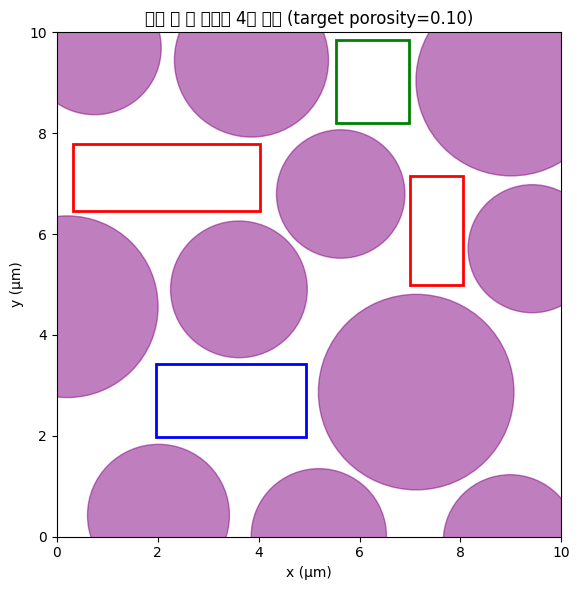

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi

# 이전에 정의된 circle_rect_area 및 find_largest_empty_rectangle 함수는 여기에 포함되었다고 가정합니다.
# (사용자의 이전 코드를 그대로 사용하시면 됩니다.)
# ... (circle_rect_area 함수 정의) ...
# ... (find_largest_empty_rectangle 함수 정의) ...


# ---------------------------------------------------------------
# 4) 메인: 원 배치 후, 격자화 → 빈 사각형 탐색 → 시각화 (2개 추가)
# ---------------------------------------------------------------
if __name__ == "__main__":
    # (4-1)  LFP(원) 배치 파라미터
    domain_size = 10              # 도메인: 0~10 μm
    target_porosity = 0.1         # 목표 기공률 10%
    np.random.seed(3)

    # (4-2)  원 배치 함수 호출 → (x,y,r) 리스트 얻기
    # increase_radius_to_target_porosity 함수도 이전 셀에 정의되었다고 가정합니다.
    lfp_positions = increase_radius_to_target_porosity(
        domain_size=domain_size,
        min_r_LFP=1.25,
        max_r_LFP=2.5,
        target_porosity=target_porosity,
        max_attempts=10000
    )

    # (4-3) “격자 해상도” 설정 (예: 200×200 픽셀)
    grid_size = 200
    H = W = grid_size

    # (4-4) 장애물 맵 생성: 도메인 내 각 픽셀(격자) 중심이
    #       원 안쪽에 속하면 1, 아니면 0.
    # find_largest_empty_rectangle 함수가 이 맵을 수정하지 않도록 복사본을 사용합니다.
    initial_obstacle_map = np.zeros((H, W), dtype=np.uint8)
    dx = domain_size / W
    dy = domain_size / H

    for i in range(H):
        for j in range(W):
            x_center = (j + 0.5) * dx
            y_center = (i + 0.5) * dy

            for (cx, cy, cr) in lfp_positions:
                if (x_center - cx)**2 + (y_center - cy)**2 <= cr**2:
                    initial_obstacle_map[i, j] = 1
                    break

    # (4-5) 가장 큰 빈 직사각형 3개 찾기
    found_rectangles_pix = []
    current_obstacle_map = initial_obstacle_map.copy() # 맵 복사하여 사용

    for k in range(4): # 가장 큰 사각형 3개 찾기
        row0, col0, height_pix, width_pix = find_largest_empty_rectangle(current_obstacle_map)

        # 찾은 사각형이 유효한 크기인지 확인 (예: 최소 1x1 픽셀)
        if width_pix > 0 and height_pix > 0:
            found_rectangles_pix.append((row0, col0, height_pix, width_pix))

            # 찾은 사각형 영역을 임시로 장애물로 표시하여 다음 탐색에서 제외
            # (이 부분을 1로 채우면 다음번 find_largest_empty_rectangle 호출 시 이 영역은 빈 공간으로 간주되지 않습니다)
            current_obstacle_map[row0 : row0 + height_pix, col0 : col0 + width_pix] = 1
        else:
            # 더 이상 유효한 크기의 빈 사각형이 없으면 중단
            break

    # (4-6) 픽셀 단위 결과 → 실제 도메인 좌표(μm)로 변환 및 크기 조절
    found_rectangles_mu = []
    size_reduction_factor = 0.85 # 예: 너비/높이를 5% 줄임

    for (row0, col0, height_pix, width_pix) in found_rectangles_pix:
        # 원래 크기 계산
        w_rect_orig = width_pix * dx
        h_rect_orig = height_pix * dy

        # 줄어든 크기 계산
        w_rect_reduced = w_rect_orig * size_reduction_factor
        h_rect_reduced = h_rect_orig * size_reduction_factor

        # 크기 줄어든 만큼 시작 위치 조정 (가운데를 기준으로 줄어들도록)
        x_rect = col0 * dx + (w_rect_orig - w_rect_reduced) / 2.0
        y_rect = row0 * dy + (h_rect_orig - h_rect_reduced) / 2.0

        found_rectangles_mu.append((x_rect, y_rect, w_rect_reduced, h_rect_reduced))

        print(f"찾은 빈 직사각형 {len(found_rectangles_mu)} (픽셀 기준):", (row0, col0, height_pix, width_pix))
        print(f"실제 좌표(μm): x={x_rect:.2f}, y={y_rect:.2f}, width={w_rect_reduced:.2f}, height={h_rect_reduced:.2f}")


    # (4-7) 시각화: 원 + 가장 큰 빈 직사각형들
    fig, ax = plt.subplots(figsize=(6, 6))

    # • 원( LFP ) 그리기 (보라색, 반투명)
    for (cx, cy, cr) in lfp_positions:
        circ = patches.Circle((cx, cy), cr, color='purple', alpha=0.5)
        ax.add_patch(circ)

    # • 찾은 빈 직사각형들 그리기 (빨간 테두리, 면색 투명)
    colors = ['red', 'blue', 'green'] # 각 사각형에 다른 색상 부여 (선택 사항)
    for i, (x_rect, y_rect, w_rect, h_rect) in enumerate(found_rectangles_mu):
         rect = patches.Rectangle(
            (x_rect, y_rect),
            w_rect,
            h_rect,
            linewidth=2,
            edgecolor=colors[i % len(colors)], # 색상 순환
            facecolor='none'
        )
         ax.add_patch(rect)


    # • 도메인 축 설정
    ax.set_xlim(0, domain_size)
    ax.set_ylim(0, domain_size)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
    ax.set_title(f"가장 큰 빈 사각형 {len(found_rectangles_mu)}개 표시 (target porosity={target_porosity:.2f})")

    plt.tight_layout()
    plt.show()

LFP 배치 위치: (7.12, 2.87), 반지름: 1.94, 기공률: 88.19%
LFP 배치 위치: (9.01, 9.04), 반지름: 1.89, 기공률: 76.43%
LFP 배치 위치: (2.01, 0.42), 반지름: 1.41, 기공률: 69.90%
LFP 배치 위치: (0.20, 4.56), 반지름: 1.80, 기공률: 59.20%
LFP 배치 위치: (3.86, 9.45), 반지름: 1.53, 기공률: 51.50%
LFP 배치 위치: (0.75, 9.69), 반지름: 1.32, 기공률: 45.74%
LFP 배치 위치: (3.61, 4.90), 반지름: 1.36, 기공률: 39.97%
LFP 배치 위치: (9.42, 5.71), 반지름: 1.27, 기공률: 34.65%
LFP 배치 위치: (8.98, -0.09), 반지름: 1.32, 기공률: 28.87%
LFP 배치 위치: (5.63, 6.79), 반지름: 1.27, 기공률: 23.77%
LFP 배치 위치: (5.19, 0.01), 반지름: 1.34, 기공률: 17.84%
Final porosity: 17.84%
찾은 빈 직사각형 1 (픽셀 기준): (np.int64(127), 0, np.int64(31), 87)
실제 좌표(μm): x=0.33, y=6.47, width=3.70, height=1.32, angle=-3.00도
찾은 빈 직사각형 2 (픽셀 기준): (np.int64(37), 34, np.int64(34), 70)
실제 좌표(μm): x=1.96, y=1.98, width=2.98, height=1.45, angle=-10.00도
찾은 빈 직사각형 3 (픽셀 기준): (np.int64(161), 108, np.int64(39), 34)
실제 좌표(μm): x=5.53, y=8.20, width=1.45, height=1.66, angle=0.00도
찾은 빈 직사각형 4 (픽셀 기준): (np.int64(96), 138, np.int64(51), 25)
실제 좌표(μm): x=6.99,

<ipython-input-46-9f5a1f86550a>:134: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-9f5a1f86550a>:134: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-9f5a1f86550a>:134: UserWarning: Glyph 53360 (\N{HANGUL SYLLABLE KEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-9f5a1f86550a>:134: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-9f5a1f86550a>:134: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-9f5a1f86550a>:134: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-9f5a1f86550a>:134: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layou

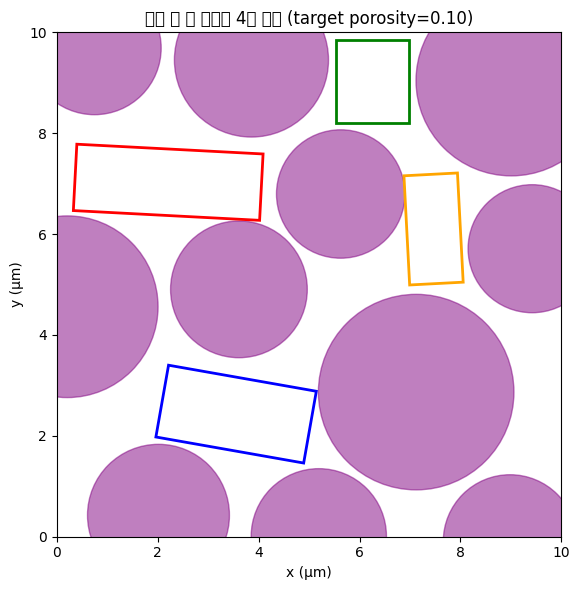

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi

# 이전에 정의된 circle_rect_area 및 find_largest_empty_rectangle 함수는 여기에 포함되었다고 가정합니다.
# (사용자의 이전 코드를 그대로 사용하시면 됩니다.)
# ... (circle_rect_area 함수 정의) ...
# ... (find_largest_empty_rectangle 함수 정의) ...


# ---------------------------------------------------------------
# 4) 메인: 원 배치 후, 격자화 → 빈 사각형 탐색 → 시각화 (2개 추가)
# ---------------------------------------------------------------
if __name__ == "__main__":
    # (4-1)  LFP(원) 배치 파라미터
    domain_size = 10              # 도메인: 0~10 μm
    target_porosity = 0.1         # 목표 기공률 10%
    np.random.seed(3)

    # (4-2)  원 배치 함수 호출 → (x,y,r) 리스트 얻기
    # increase_radius_to_target_porosity 함수도 이전 셀에 정의되었다고 가정합니다.
    lfp_positions = increase_radius_to_target_porosity(
        domain_size=domain_size,
        min_r_LFP=1.25,
        max_r_LFP=2.5,
        target_porosity=target_porosity,
        max_attempts=10000
    )

    # (4-3) “격자 해상도” 설정 (예: 200×200 픽셀)
    grid_size = 200
    H = W = grid_size

    # (4-4) 장애물 맵 생성: 도메인 내 각 픽셀(격자) 중심이
    #       원 안쪽에 속하면 1, 아니면 0.
    # find_largest_empty_rectangle 함수가 이 맵을 수정하지 않도록 복사본을 사용합니다.
    initial_obstacle_map = np.zeros((H, W), dtype=np.uint8)
    dx = domain_size / W
    dy = domain_size / H

    for i in range(H):
        for j in range(W):
            x_center = (j + 0.5) * dx
            y_center = (i + 0.5) * dy

            for (cx, cy, cr) in lfp_positions:
                if (x_center - cx)**2 + (y_center - cy)**2 <= cr**2:
                    initial_obstacle_map[i, j] = 1
                    break

    # (4-5) 가장 큰 빈 직사각형 3개 찾기
    found_rectangles_pix = []
    current_obstacle_map = initial_obstacle_map.copy() # 맵 복사하여 사용

    # 4개까지 찾도록 수정 (첫 번째, 두 번째, 세 번째 빈 공간 확보를 위해)
    for k in range(4):
        row0, col0, height_pix, width_pix = find_largest_empty_rectangle(current_obstacle_map)

        # 찾은 사각형이 유효한 크기인지 확인 (예: 최소 1x1 픽셀)
        if width_pix > 0 and height_pix > 0:
            found_rectangles_pix.append((row0, col0, height_pix, width_pix))

            # 찾은 사각형 영역을 임시로 장애물로 표시하여 다음 탐색에서 제외
            current_obstacle_map[row0 : row0 + height_pix, col0 : col0 + width_pix] = 1
        else:
            # 더 이상 유효한 크기의 빈 사각형이 없으면 중단
            break

    # (4-6) 픽셀 단위 결과 → 실제 도메인 좌표(μm)로 변환 및 크기 조절, 회전 각도 할당
    found_rectangles_mu = []
    size_reduction_factor = 0.85 # 예: 너비/높이를 5% 줄임

    # 각 사각형에 적용할 회전 각도 리스트 (찾는 사각형 개수와 맞게 설정)
    # 예시: 첫 번째 사각형은 5도, 두 번째는 10도, 세 번째는 0도, 네 번째는 -5도 회전
    rotation_angles_deg = [-3, -10, 0, 3]

    for i, (row0, col0, height_pix, width_pix) in enumerate(found_rectangles_pix):
        # 원래 크기 계산
        w_rect_orig = width_pix * dx
        h_rect_orig = height_pix * dy

        # 줄어든 크기 계산
        w_rect_reduced = w_rect_orig * size_reduction_factor
        h_rect_reduced = h_rect_orig * size_reduction_factor

        # 크기 줄어든 만큼 시작 위치 조정 (가운데를 기준으로 줄어들도록)
        x_rect = col0 * dx + (w_rect_orig - w_rect_reduced) / 2.0
        y_rect = row0 * dy + (h_rect_orig - h_rect_reduced) / 2.0

        # 현재 사각형에 적용할 회전 각도 가져오기 (리스트 길이 벗어나지 않게 처리)
        angle_to_apply = rotation_angles_deg[i % len(rotation_angles_deg)]


        found_rectangles_mu.append((x_rect, y_rect, w_rect_reduced, h_rect_reduced, angle_to_apply))

        print(f"찾은 빈 직사각형 {len(found_rectangles_mu)} (픽셀 기준):", (row0, col0, height_pix, width_pix))
        print(f"실제 좌표(μm): x={x_rect:.2f}, y={y_rect:.2f}, width={w_rect_reduced:.2f}, height={h_rect_reduced:.2f}, angle={angle_to_apply:.2f}도")


    # (4-7) 시각화: 원 + 가장 큰 빈 직사각형들 (회전 적용)
    fig, ax = plt.subplots(figsize=(6, 6))

    # • 원( LFP ) 그리기 (보라색, 반투명)
    for (cx, cy, cr) in lfp_positions:
        circ = patches.Circle((cx, cy), cr, color='purple', alpha=0.5)
        ax.add_patch(circ)

    # • 찾은 빈 직사각형들 그리기 (빨간 테두리, 면색 투명)
    colors = ['red', 'blue', 'green', 'orange'] # 각 사각형에 다른 색상 부여 (찾는 사각형 개수와 맞게)

    # found_rectangles_mu 리스트에 회전 각도 정보가 추가되었으므로 구조 변경
    for i, (x_rect, y_rect, w_rect, h_rect, angle_to_apply) in enumerate(found_rectangles_mu):
         rect = patches.Rectangle(
            (x_rect, y_rect),
            w_rect,
            h_rect,
            linewidth=2,
            edgecolor=colors[i % len(colors)], # 색상 순환
            facecolor='none',
            angle=angle_to_apply # 개별 회전 각도 적용
        )
         ax.add_patch(rect)


    # • 도메인 축 설정
    ax.set_xlim(0, domain_size)
    ax.set_ylim(0, domain_size)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
    ax.set_title(f"가장 큰 빈 사각형 {len(found_rectangles_mu)}개 표시 (target porosity={target_porosity:.2f})")

    plt.tight_layout()
    plt.show()

LFP 배치 위치: (7.12, 2.87), 반지름: 1.94, 기공률: 88.19%
LFP 배치 위치: (9.01, 9.04), 반지름: 1.89, 기공률: 76.43%
LFP 배치 위치: (2.01, 0.42), 반지름: 1.41, 기공률: 69.90%
LFP 배치 위치: (0.20, 4.56), 반지름: 1.80, 기공률: 59.20%
LFP 배치 위치: (3.86, 9.45), 반지름: 1.53, 기공률: 51.50%
LFP 배치 위치: (0.75, 9.69), 반지름: 1.32, 기공률: 45.74%
LFP 배치 위치: (3.61, 4.90), 반지름: 1.36, 기공률: 39.97%
LFP 배치 위치: (9.42, 5.71), 반지름: 1.27, 기공률: 34.65%
LFP 배치 위치: (8.98, -0.09), 반지름: 1.32, 기공률: 28.87%
LFP 배치 위치: (5.63, 6.79), 반지름: 1.27, 기공률: 23.77%
LFP 배치 위치: (5.19, 0.01), 반지름: 1.34, 기공률: 17.84%
Final porosity: 17.84%
찾은 빈 직사각형 1 (픽셀 기준): (np.int64(127), 0, np.int64(31), 87)
실제 좌표(μm): x=0.11, y=6.39, width=4.13, height=1.47, angle=-3.00도
찾은 빈 직사각형 2 (픽셀 기준): (np.int64(37), 34, np.int64(34), 70)
실제 좌표(μm): x=1.79, y=1.89, width=3.32, height=1.61, angle=-3.00도
찾은 빈 직사각형 3 (픽셀 기준): (np.int64(161), 108, np.int64(39), 34)
실제 좌표(μm): x=5.44, y=8.10, width=1.61, height=1.85, angle=0.00도
찾은 빈 직사각형 4 (픽셀 기준): (np.int64(96), 138, np.int64(51), 25)
실제 좌표(μm): x=6.93, 

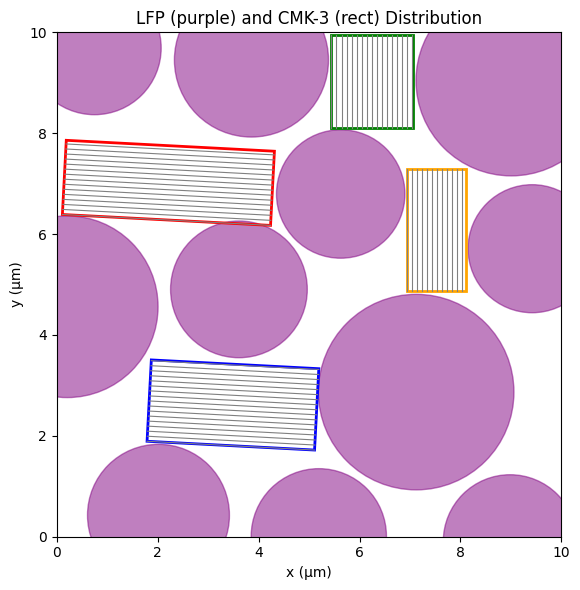

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi, cos, sin, radians

# 이전에 정의된 circle_rect_area 및 find_largest_empty_rectangle 함수는 여기에 포함되었다고 가정합니다.
# (사용자의 이전 코드를 그대로 사용하시면 됩니다.)
# ... (circle_rect_area 함수 정의) ...
# ... (find_largest_empty_rectangle 함수 정의) ...


# ---------------------------------------------------------------
# 4) 메인: 원 배치 후, 격자화 → 빈 사각형 탐색 → 시각화 (2개 추가)
# ---------------------------------------------------------------
if __name__ == "__main__":
    # (4-1)  LFP(원) 배치 파라미터
    domain_size = 10              # 도메인: 0~10 μm
    target_porosity = 0.1         # 목표 기공률 10%
    np.random.seed(3)

    # (4-2)  원 배치 함수 호출 → (x,y,r) 리스트 얻기
    # increase_radius_to_target_porosity 함수도 이전 셀에 정의되었다고 가정합니다.
    lfp_positions = increase_radius_to_target_porosity(
        domain_size=domain_size,
        min_r_LFP=1.25,
        max_r_LFP=2.5,
        target_porosity=target_porosity,
        max_attempts=10000
    )

    # (4-3) “격자 해상도” 설정 (예: 200×200 픽셀)
    grid_size = 200
    H = W = grid_size

    # (4-4) 장애물 맵 생성: 도메인 내 각 픽셀(격자) 중심이
    #       원 안쪽에 속하면 1, 아니면 0.
    # find_largest_empty_rectangle 함수가 이 맵을 수정하지 않도록 복사본을 사용합니다.
    initial_obstacle_map = np.zeros((H, W), dtype=np.uint8)
    dx = domain_size / W
    dy = domain_size / H

    for i in range(H):
        for j in range(W):
            x_center = (j + 0.5) * dx
            y_center = (i + 0.5) * dy

            for (cx, cy, cr) in lfp_positions:
                if (x_center - cx)**2 + (y_center - cy)**2 <= cr**2:
                    initial_obstacle_map[i, j] = 1
                    break

    # (4-5) 가장 큰 빈 직사각형 3개 찾기
    found_rectangles_pix = []
    current_obstacle_map = initial_obstacle_map.copy() # 맵 복사하여 사용

    # 4개까지 찾도록 수정 (첫 번째, 두 번째, 세 번째 빈 공간 확보를 위해)
    for k in range(4):
        row0, col0, height_pix, width_pix = find_largest_empty_rectangle(current_obstacle_map)

        # 찾은 사각형이 유효한 크기인지 확인 (예: 최소 1x1 픽셀)
        if width_pix > 0 and height_pix > 0:
            found_rectangles_pix.append((row0, col0, height_pix, width_pix))

            # 찾은 사각형 영역을 임시로 장애물로 표시하여 다음 탐색에서 제외
            current_obstacle_map[row0 : row0 + height_pix, col0 : col0 + width_pix] = 1
        else:
            # 더 이상 유효한 크기의 빈 사각형이 없으면 중단
            break

    # (4-6) 픽셀 단위 결과 → 실제 도메인 좌표(μm)로 변환 및 크기 조절, 회전 각도 할당
    found_rectangles_mu = []
    size_reduction_factor = 0.95 # 예: 너비/높이를 15% 줄임 (이전 요청값 적용)

    # 각 사각형에 적용할 회전 각도 리스트 (이전 요청값 적용)
    # 예시: 첫 번째 사각형은 -3도, 두 번째는 -10도, 세 번째는 0도, 네 번째는 3도 회전
    rotation_angles_deg = [-3, -3, 0, 0]

    for i, (row0, col0, height_pix, width_pix) in enumerate(found_rectangles_pix):
        # 원래 크기 계산
        w_rect_orig = width_pix * dx
        h_rect_orig = height_pix * dy

        # 줄어든 크기 계산
        w_rect_reduced = w_rect_orig * size_reduction_factor
        h_rect_reduced = h_rect_orig * size_reduction_factor

        # 크기 줄어든 만큼 시작 위치 조정 (가운데를 기준으로 줄어들도록)
        x_rect_bottom_left = col0 * dx + (w_rect_orig - w_rect_reduced) / 2.0
        y_rect_bottom_left = row0 * dy + (h_rect_orig - h_rect_reduced) / 2.0

        # 현재 사각형에 적용할 회전 각도 가져오기 (리스트 길이 벗어나지 않게 처리)
        angle_to_apply_deg = rotation_angles_deg[i % len(rotation_angles_deg)]

        found_rectangles_mu.append((x_rect_bottom_left, y_rect_bottom_left, w_rect_reduced, h_rect_reduced, angle_to_apply_deg))

        print(f"찾은 빈 직사각형 {len(found_rectangles_mu)} (픽셀 기준):", (row0, col0, height_pix, width_pix))
        print(f"실제 좌표(μm): x={x_rect_bottom_left:.2f}, y={y_rect_bottom_left:.2f}, width={w_rect_reduced:.2f}, height={h_rect_reduced:.2f}, angle={angle_to_apply_deg:.2f}도")


    # (4-7) 시각화: 원 + 가장 큰 빈 직사각형들 (회전 적용) + 내부 선분
    fig, ax = plt.subplots(figsize=(6, 6))

    # • 원( LFP ) 그리기 (보라색, 반투명)
    for (cx, cy, cr) in lfp_positions:
        circ = patches.Circle((cx, cy), cr, color='purple', alpha=0.5)
        ax.add_patch(circ)

    # • 찾은 빈 직사각형들 그리기 (테두리) 및 내부 선분 그리기
    colors = ['red', 'blue', 'green', 'orange'] # 각 사각형에 다른 색상 부여
    line_color = 'gray' # 선분 색상
    line_linewidth = 0.8 # 선분 두께
    line_spacing = 0.1 # 선분 간 간격 (μm 단위)

    # found_rectangles_mu 리스트에 회전 각도 정보가 추가되었으므로 구조 변경
    for i, (x_rect_bl, y_rect_bl, w_rect, h_rect, angle_to_apply_deg) in enumerate(found_rectangles_mu):

        # 1. 직사각형 테두리 그리기
        rect = patches.Rectangle(
            (x_rect_bl, y_rect_bl),
            w_rect,
            h_rect,
            linewidth=2,
            edgecolor=colors[i % len(colors)], # 색상 순환
            facecolor='none',
            angle=angle_to_apply_deg
        )
        ax.add_patch(rect)

        # 2. 직사각형 내부 선분 그리기
        # 회전 각도를 라디안으로 변환
        angle_rad = radians(angle_to_apply_deg)

        # 직사각형의 긴 변과 짧은 변 판단
        if w_rect >= h_rect:
            # 너비가 더 길거나 같으면, 높이 방향으로 선분 배치
            longer_side_len = w_rect
            shorter_side_len = h_rect
            # 선분은 긴 변(너비)에 평행하게 그려짐
            # 시작점 기준: 짧은 변(높이)의 0부터 끝까지 선분 배치
            num_lines = int(shorter_side_len / line_spacing)
            # 선분 시작점과 끝점 계산
            for k in range(num_lines + 1):
                # 짧은 변 방향으로 이동할 거리
                dist_along_shorter = k * line_spacing
                if k * line_spacing > shorter_side_len: # 마지막 선분이 너무 길면 조절
                    dist_along_shorter = shorter_side_len

                # 선분의 시작점 (짧은 변의 한쪽 끝에서 dist_along_shorter 만큼 이동한 점)
                # 회전 변환 적용: (x', y') = (x*cos - y*sin, x*sin + y*cos)
                # 사각형 왼쪽 아래 꼭짓점 (x_rect_bl, y_rect_bl)을 원점으로 생각
                start_x_local = 0
                start_y_local = dist_along_shorter
                # 회전된 로컬 시작점
                rotated_start_x_local = start_x_local * cos(angle_rad) - start_y_local * sin(angle_rad)
                rotated_start_y_local = start_x_local * sin(angle_rad) + start_y_local * cos(angle_rad)
                # 실제 도메인 좌표에서의 시작점
                start_x = x_rect_bl + rotated_start_x_local
                start_y = y_rect_bl + rotated_start_y_local

                # 선분의 끝점 (시작점에서 긴 변(너비) 길이만큼 이동한 점)
                end_x_local = longer_side_len
                end_y_local = dist_along_shorter # 짧은 변 방향 이동 거리는 동일
                 # 회전된 로컬 끝점
                rotated_end_x_local = end_x_local * cos(angle_rad) - end_y_local * sin(angle_rad)
                rotated_end_y_local = end_x_local * sin(angle_rad) + end_y_local * cos(angle_rad)
                # 실제 도메인 좌표에서의 끝점
                end_x = x_rect_bl + rotated_end_x_local
                end_y = y_rect_bl + rotated_end_y_local

                # 선분 그리기
                ax.plot([start_x, end_x], [start_y, end_y], color=line_color, linewidth=line_linewidth)


        else:
            # 높이가 더 길면, 너비 방향으로 선분 배치
            longer_side_len = h_rect
            shorter_side_len = w_rect
            # 선분은 긴 변(높이)에 평행하게 그려짐
            # 시작점 기준: 짧은 변(너비)의 0부터 끝까지 선분 배치
            num_lines = int(shorter_side_len / line_spacing)
            # 선분 시작점과 끝점 계산
            for k in range(num_lines + 1):
                 # 짧은 변 방향(너비)으로 이동할 거리
                dist_along_shorter = k * line_spacing
                if k * line_spacing > shorter_side_len: # 마지막 선분이 너무 길면 조절
                    dist_along_shorter = shorter_side_len

                # 선분의 시작점 (짧은 변(너비)의 한쪽 끝에서 dist_along_shorter 만큼 이동한 점)
                # 회전 변환 적용: (x', y') = (x*cos - y*sin, x*sin + y*cos)
                # 사각형 왼쪽 아래 꼭짓점 (x_rect_bl, y_rect_bl)을 원점으로 생각
                start_x_local = dist_along_shorter
                start_y_local = 0
                 # 회전된 로컬 시작점
                rotated_start_x_local = start_x_local * cos(angle_rad) - start_y_local * sin(angle_rad)
                rotated_start_y_local = start_x_local * sin(angle_rad) + start_y_local * cos(angle_rad)
                 # 실제 도메인 좌표에서의 시작점
                start_x = x_rect_bl + rotated_start_x_local
                start_y = y_rect_bl + rotated_start_y_local


                # 선분의 끝점 (시작점에서 긴 변(높이) 길이만큼 이동한 점)
                end_x_local = dist_along_shorter # 짧은 변 방향 이동 거리는 동일
                end_y_local = longer_side_len
                 # 회전된 로컬 끝점
                rotated_end_x_local = end_x_local * cos(angle_rad) - end_y_local * sin(angle_rad)
                rotated_end_y_local = end_x_local * sin(angle_rad) + end_y_local * cos(angle_rad)
                # 실제 도메인 좌표에서의 끝점
                end_x = x_rect_bl + rotated_end_x_local
                end_y = y_rect_bl + rotated_end_y_local


                # 선분 그리기
                ax.plot([start_x, end_x], [start_y, end_y], color=line_color, linewidth=line_linewidth)


    # • 도메인 축 설정
    ax.set_xlim(0, domain_size)
    ax.set_ylim(0, domain_size)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
    ax.set_title(f"LFP (purple) and CMK-3 (rect) Distribution")

    plt.tight_layout()
    plt.show()

LFP 배치 위치: (7.12, 2.87), 반지름: 1.94, 기공률: 88.19%
LFP 배치 위치: (9.01, 9.04), 반지름: 1.89, 기공률: 76.43%
LFP 배치 위치: (2.01, 0.42), 반지름: 1.41, 기공률: 69.90%
LFP 배치 위치: (0.20, 4.56), 반지름: 1.80, 기공률: 59.20%
LFP 배치 위치: (3.86, 9.45), 반지름: 1.53, 기공률: 51.50%
LFP 배치 위치: (0.75, 9.69), 반지름: 1.32, 기공률: 45.74%
LFP 배치 위치: (3.61, 4.90), 반지름: 1.36, 기공률: 39.97%
LFP 배치 위치: (9.42, 5.71), 반지름: 1.27, 기공률: 34.65%
LFP 배치 위치: (8.98, -0.09), 반지름: 1.32, 기공률: 28.87%
LFP 배치 위치: (5.63, 6.79), 반지름: 1.27, 기공률: 23.77%
LFP 배치 위치: (5.19, 0.01), 반지름: 1.34, 기공률: 17.84%
Final porosity: 17.84%
찾은 빈 직사각형 1 (픽셀 기준): (np.int64(127), 0, np.int64(31), 87)
실제 좌표(μm): x=0.00, y=6.35, width=4.35, height=1.55, angle=-3.00도
찾은 빈 직사각형 2 (픽셀 기준): (np.int64(37), 34, np.int64(34), 70)
실제 좌표(μm): x=1.70, y=1.85, width=3.50, height=1.70, angle=-3.00도
찾은 빈 직사각형 3 (픽셀 기준): (np.int64(161), 108, np.int64(39), 34)
실제 좌표(μm): x=5.40, y=8.05, width=1.70, height=1.95, angle=-1.00도
찾은 빈 직사각형 4 (픽셀 기준): (np.int64(96), 138, np.int64(51), 25)
실제 좌표(μm): x=6.90,

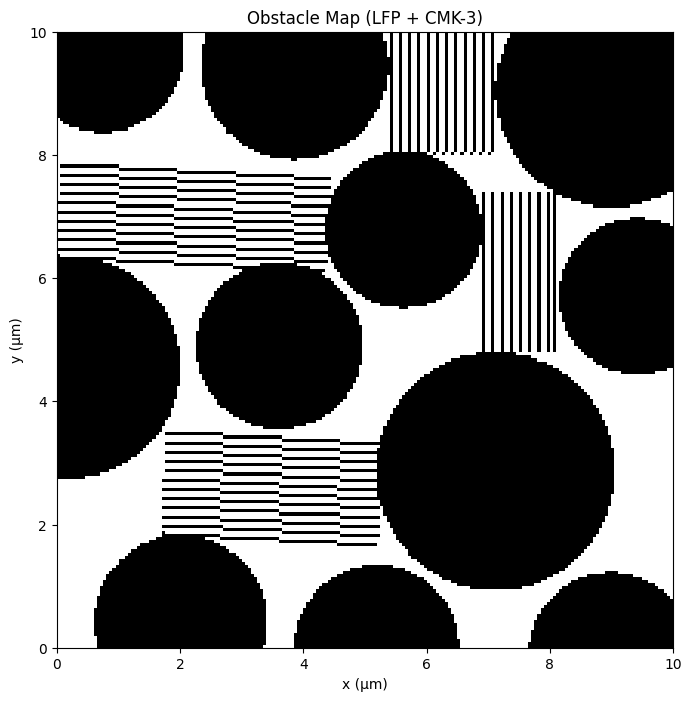

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi, cos, sin, radians

# 이전에 정의된 circle_rect_area 및 find_largest_empty_rectangle 함수는 여기에 포함되었다고 가정합니다.
# (사용자의 이전 코드를 그대로 사용하시면 됩니다.)
# ... (circle_rect_area 함수 정의) ...
# ... (find_largest_empty_rectangle 함수 정의) ...


# ---------------------------------------------------------------
# 4) 메인: 원 배치 후, 격자화 → 빈 사각형 탐색 → 시각화 (2개 추가)
# ---------------------------------------------------------------
if __name__ == "__main__":
    # (4-1)  LFP(원) 배치 파라미터
    domain_size = 10              # 도메인: 0~10 μm
    target_porosity = 0.1         # 목표 기공률 10%
    np.random.seed(3)

    # (4-2)  원 배치 함수 호출 → (x,y,r) 리스트 얻기
    # increase_radius_to_target_porosity 함수도 이전 셀에 정의되었다고 가정합니다.
    lfp_positions = increase_radius_to_target_porosity(
        domain_size=domain_size,
        min_r_LFP=1.25,
        max_r_LFP=2.5,
        target_porosity=target_porosity,
        max_attempts=10000
    )

    # (4-3) “격자 해상도” 설정 (예: 200×200 픽셀)
    grid_size = 200
    H = W = grid_size

    # (4-4) 장애물 맵 생성: 도메인 내 각 픽셀(격자) 중심이
    #       원 안쪽에 속하면 1, 아니면 0.
    # find_largest_empty_rectangle 함수가 이 맵을 수정하지 않도록 복사본을 사용합니다.
    initial_obstacle_map = np.zeros((H, W), dtype=np.uint8)
    dx = domain_size / W
    dy = domain_size / H

    for i in range(H):
        for j in range(W):
            x_center = (j + 0.5) * dx
            y_center = (i + 0.5) * dy

            for (cx, cy, cr) in lfp_positions:
                # 픽셀 중심이 원 안에 있는지 확인
                if (x_center - cx)**2 + (y_center - cy)**2 <= cr**2:
                    initial_obstacle_map[i, j] = 1
                    break # 이 픽셀은 이미 장애물로 표시됨

    # (4-5) 가장 큰 빈 직사각형 3개 찾기
    found_rectangles_pix = []
    current_obstacle_map = initial_obstacle_map.copy() # 맵 복사하여 사용

    # 4개까지 찾도록 수정
    for k in range(4):
        row0, col0, height_pix, width_pix = find_largest_empty_rectangle(current_obstacle_map)

        # 찾은 사각형이 유효한 크기인지 확인
        if width_pix > 0 and height_pix > 0:
            found_rectangles_pix.append((row0, col0, height_pix, width_pix))

            # 찾은 사각형 영역을 임시로 장애물로 표시하여 다음 탐색에서 제외
            current_obstacle_map[row0 : row0 + height_pix, col0 : col0 + width_pix] = 1
        else:
            # 더 이상 유효한 크기의 빈 사각형이 없으면 중단
            break

    # (4-6) 픽셀 단위 결과 → 실제 도메인 좌표(μm)로 변환 및 크기 조절, 회전 각도 할당
    found_rectangles_mu = []
    size_reduction_factor = 1 # 이전 요청값 적용

    # 각 사각형에 적용할 회전 각도 리스트 (이전 요청값 적용)
    rotation_angles_deg = [-3, -3, -1, 0]

    for i, (row0, col0, height_pix, width_pix) in enumerate(found_rectangles_pix):
        # 원래 크기 계산
        w_rect_orig = width_pix * dx
        h_rect_orig = height_pix * dy

        # 줄어든 크기 계산
        w_rect_reduced = w_rect_orig * size_reduction_factor
        h_rect_reduced = h_rect_orig * size_reduction_factor # Corrected variable name

        # 크기 줄어든 만큼 시작 위치 조정 (가운데를
        # 기준으로 줄어들도록)
        x_rect_bottom_left = col0 * dx + (w_rect_orig - w_rect_reduced) / 2.0
        y_rect_bottom_left = row0 * dy + (h_rect_orig - h_rect_reduced) / 2.0

        # 현재 사각형에 적용할 회전 각도 가져오기 (리스트 길이 벗어나지 않게 처리)
        angle_to_apply_deg = rotation_angles_deg[i % len(rotation_angles_deg)]

        found_rectangles_mu.append((x_rect_bottom_left, y_rect_bottom_left, w_rect_reduced, h_rect_reduced, angle_to_apply_deg))

        print(f"찾은 빈 직사각형 {len(found_rectangles_mu)} (픽셀 기준):", (row0, col0, height_pix, width_pix))
        print(f"실제 좌표(μm): x={x_rect_bottom_left:.2f}, y={y_rect_bottom_left:.2f}, width={w_rect_reduced:.2f}, height={h_rect_reduced:.2f}, angle={angle_to_apply_deg:.2f}도")


    # (4-7) 최종 obstacle map 생성 및 시각화
    # initial_obstacle_map을 기반으로 시작합니다 (LFP 원 포함)
    final_obstacle_map = initial_obstacle_map.copy()

    # 선분 간 간격 (μm 단위) 및 선분 두께 (픽셀 단위로 간주)
    line_spacing = 0.15 # μm
    line_pixel_thickness = 1 # 픽셀 단위로 선분의 두께 설정

    # 각 직사각형과 내부 선분을 final_obstacle_map에 그리기
    for i, (x_rect_bl, y_rect_bl, w_rect, h_rect, angle_to_apply_deg) in enumerate(found_rectangles_mu):

        # 회전 각도를 라디안으로 변환
        angle_rad = radians(angle_to_apply_deg)

        # 직사각형 테두리 그리기 (두께를 고려하여 맵에 표시)
        # Note: 정확한 회전된 직사각형 테두리를 픽셀 단위로 맵에 그리는 것은 복잡합니다.
        # 여기서는 단순화를 위해 사각형의 AABB (Axis-Aligned Bounding Box)를 기준으로
        # 맵을 업데이트하거나, 각 픽셀 중심이 회전된 사각형 내부에 있는지 판단해야 합니다.
        # 더 정확한 방법은 각 픽셀이 회전된 사각형의 경로에 얼마나 가까운지 계산하는 것입니다.
        # 여기서는 편의상 사각형 내부 전체를 채우는 방식으로 구현합니다.
        # (원래 목적이 빈 공간 찾는 것이므로, 채워도 무방할 수 있습니다.)

        # 간략화된 방법: 사각형 내부 픽셀을 모두 1로 채웁니다.
        # 더 정밀하게 하려면 각 픽셀이 회전된 사각형의 내부인지 판별하는 로직 필요
        # 여기서는 find_largest_empty_rectangle에서 사용한 픽셀 영역을 다시 활용 (크기 줄인 후)
        # 픽셀 좌표로 변환
        col0 = int(x_rect_bl / dx)
        row0 = int(y_rect_bl / dy)
        width_pix = int(w_rect / dx)
        height_pix = int(h_rect / dy)

        # 맵 범위 벗어나지 않도록 클리핑
        col_end = min(col0 + width_pix, W)
        row_end = min(row0 + height_pix, H)
        col0 = max(0, col0)
        row0 = max(0, row0)

        # 줄어든 사각형 영역을 맵에 표시 (회전은 시각화에서만 적용)
        # final_obstacle_map[row0:row_end, col0:col_end] = 1
        # Note: 이 방식은 회전을 고려하지 못하므로, 아래 선분 그리는 방식과 유사하게 픽셀 단위로 판단해야 함

        # 각 픽셀의 중심이 회전된 사각형 내부에 있는지 더 정확히 판단하는 로직 (주석 처리)
        # rect_center_x = x_rect_bl + w_rect / 2.0
        # rect_center_y = y_rect_bl + h_rect / 2.0
        # for r in range(H):
        #     for c in range(W):
        #         pixel_center_x = (c + 0.5) * dx
        #         pixel_center_y = (r + 0.5) * dy
        #         # 픽셀 중심을 사각형 중심으로 이동
        #         translated_x = pixel_center_x - rect_center_x
        #         translated_y = pixel_center_y - rect_center_y
        #         # 역회전 (픽셀을 회전되지 않은 사각형의 좌표계로 변환)
        #         inv_angle_rad = -angle_rad
        #         rotated_x = translated_x * cos(inv_angle_rad) - translated_y * sin(inv_angle_rad)
        #         rotated_y = translated_x * sin(inv_angle_rad) + translated_y * cos(inv_angle_rad)
        #         # 회전되지 않은 사각형의 AABB 내부에 있는지 확인
        #         if -w_rect/2.0 <= rotated_x <= w_rect/2.0 and -h_rect/2.0 <= rotated_y <= h_rect/2.0:
        #              final_obstacle_map[r, c] = 1


        # 선분 그리기 (픽셀 단위로 맵에 표시)
        # 선분은 사각형의 긴 변에 평행하게 그려짐
        if w_rect >= h_rect:
            # 너비가 더 길거나 같으면, 높이 방향으로 선분 배치
            shorter_side_len = h_rect
            num_lines = int(shorter_side_len / line_spacing)

            for k in range(num_lines + 1):
                dist_along_shorter = k * line_spacing
                # if k * line_spacing > shorter_side_len: # 마지막 선분이 너무 길면 조절 (선분 끝점이 사각형 경계를 벗어나지 않도록 해야 함)
                #     dist_along_shorter = shorter_side_len # 이 로직은 선분 끝점을 정확히 맞추는 데 사용되지만, 맵 그리기에서는 픽셀 단위 판단으로 대체

                # 선분의 시작점 (로컬 좌표)
                start_x_local = 0
                start_y_local = dist_along_shorter

                # 선분의 끝점 (로컬 좌표)
                end_x_local = w_rect # 긴 변 길이 (너비)
                end_y_local = dist_along_shorter

                # 선분을 따라 픽셀을 찍기 위해 선분의 물리적 길이를 계산
                line_physical_length = w_rect

                # 선분 위에 있는 각 픽셀을 판단
                # 시작점에서 끝점까지 일정한 스텝으로 이동하며 해당 픽셀을 맵에 표시
                num_points = max(2, int(line_physical_length / (min(dx, dy) / line_pixel_thickness))) # 선분 길이 / (픽셀 해상도 / 선분 두께)
                for step in range(num_points + 1):
                    t = step / num_points # 0부터 1까지 변화하는 비율

                    # 선분 위의 현재 점 (로컬 좌표)
                    current_x_local = start_x_local + t * (end_x_local - start_x_local)
                    current_y_local = start_y_local + t * (end_y_local - start_y_local)

                    # 회전 변환 적용
                    rotated_x_local = current_x_local * cos(angle_rad) - current_y_local * sin(angle_rad)
                    rotated_y_local = current_x_local * sin(angle_rad) + current_y_local * cos(angle_rad)

                    # 실제 도메인 좌표
                    current_x_mu = x_rect_bl + rotated_x_local
                    current_y_mu = y_rect_bl + rotated_y_local

                    # 해당 점이 속한 픽셀 좌표 계산
                    pixel_col = int(current_x_mu / dx)
                    pixel_row = int(current_y_mu / dy)

                    # 맵 범위 벗어나지 않도록 확인하고 맵에 표시
                    if 0 <= pixel_row < H and 0 <= pixel_col < W:
                        final_obstacle_map[pixel_row, pixel_col] = 1

        else:
            # 높이가 더 길면, 너비 방향으로 선분 배치
            shorter_side_len = w_rect
            num_lines = int(shorter_side_len / line_spacing)

            for k in range(num_lines + 1):
                dist_along_shorter = k * line_spacing
                 # if k * line_spacing > shorter_side_len: # 마지막 선분이 너무 길면 조절
                #     dist_along_shorter = shorter_side_len

                # 선분의 시작점 (로컬 좌표)
                start_x_local = dist_along_shorter
                start_y_local = 0

                # 선분의 끝점 (로컬 좌표)
                end_x_local = dist_along_shorter
                end_y_local = h_rect # 긴 변 길이 (높이)

                # 선분을 따라 픽셀을 찍기 위해 선분의 물리적 길이를 계산
                line_physical_length = h_rect

                 # 선분 위에 있는 각 픽셀을 판단
                num_points = max(2, int(line_physical_length / (min(dx, dy) / line_pixel_thickness)))
                for step in range(num_points + 1):
                    t = step / num_points # 0부터 1까지 변화하는 비율

                    # 선분 위의 현재 점 (로컬 좌표)
                    current_x_local = start_x_local + t * (end_x_local - start_x_local)
                    current_y_local = start_y_local + t * (end_y_local - start_y_local)

                     # 회전 변환 적용
                    rotated_x_local = current_x_local * cos(angle_rad) - current_y_local * sin(angle_rad)
                    rotated_y_local = current_x_local * sin(angle_rad) + current_y_local * cos(angle_rad)

                    # 실제 도메인 좌표
                    current_x_mu = x_rect_bl + rotated_x_local
                    current_y_mu = y_rect_bl + rotated_y_local

                    # 해당 점이 속한 픽셀 좌표 계산
                    pixel_col = int(current_x_mu / dx)
                    pixel_row = int(current_y_mu / dy)

                    # 맵 범위 벗어나지 않도록 확인하고 맵에 표시
                    if 0 <= pixel_row < H and 0 <= pixel_col < W:
                        final_obstacle_map[pixel_row, pixel_col] = 1


    # (4-8) 최종 장애물 맵 시각화
    plt.figure(figsize=(8, 8))
    # imshow는 행렬을 이미지로 표시. origin='lower'는 0,0을 왼쪽 아래로, cmap='Greys'는 흑백으로.
    # extent는 축 범위를 설정
    plt.imshow(final_obstacle_map, origin='lower', cmap='Greys', extent=[0, domain_size, 0, domain_size])
    plt.title(f"Obstacle Map (LFP + CMK-3)")
    plt.xlabel("x (μm)")
    plt.ylabel("y (μm)")
    plt.grid(False) # 격자 라인 숨기기
    plt.show()

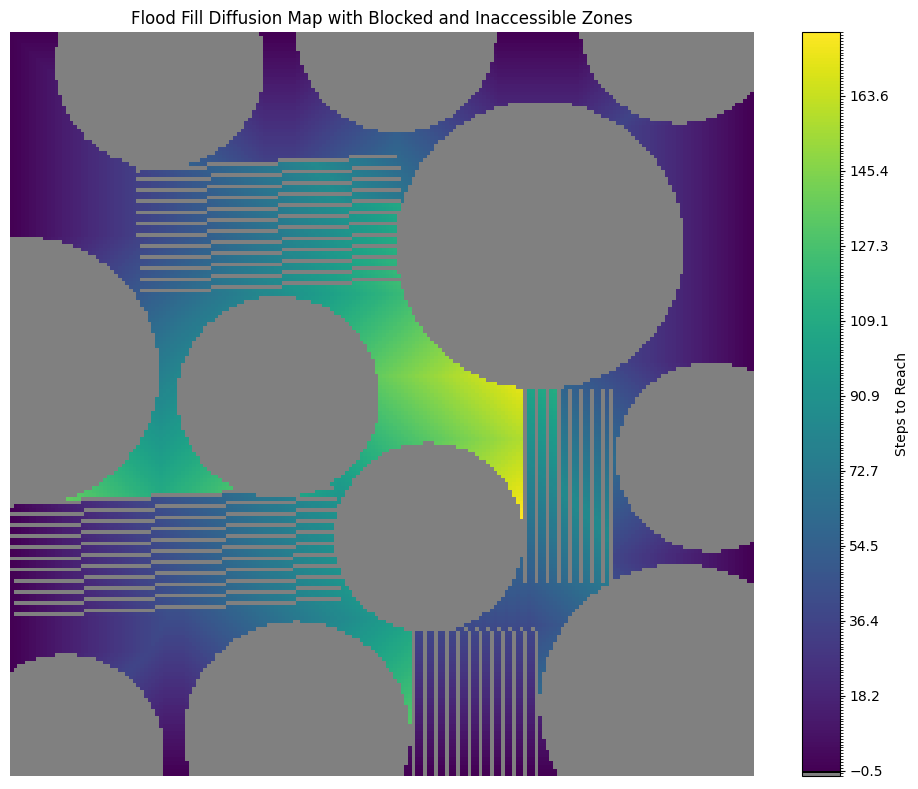

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from matplotlib.colors import ListedColormap, BoundaryNorm

# Flood Fill 알고리즘
def flood_fill_time_map(final_obstacle_map, start_points):
    h, w = final_obstacle_map.shape
    time_map = np.full((h, w), np.inf)
    visited = np.zeros((h, w), dtype=bool)
    queue = deque()

    for y, x in start_points:
        if final_obstacle_map[y, x] == 0:
            queue.append((y, x, 0))
            time_map[y, x] = 0
            visited[y, x] = True

    while queue:
        y, x, t = queue.popleft()
        for dy, dx in [(-1,0), (1,0), (0,-1), (0,1)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                if not visited[ny, nx] and final_obstacle_map[ny, nx] == 0:
                    visited[ny, nx] = True
                    time_map[ny, nx] = t + 1
                    queue.append((ny, nx, t + 1))
    return time_map

# 가장자리에서 시작점 찾기
def get_edge_starts(final_obstacle_map):
    starts = []
    h, w = final_obstacle_map.shape
    for i in range(h):
        if final_obstacle_map[i, 0] == 0:
            starts.append((i, 0))
        if final_obstacle_map[i, w-1] == 0:
            starts.append((i, w-1))
    for j in range(w):
        if final_obstacle_map[0, j] == 0:
            starts.append((0, j))
        if final_obstacle_map[h-1, j] == 0:
            starts.append((h-1, j))
    return starts

# Flood Fill 실행
start_points = get_edge_starts(final_obstacle_map)
time_map = flood_fill_time_map(final_obstacle_map, start_points)

# 시각화용 맵 생성
visual_map = np.zeros_like(time_map)
visual_map[~np.isinf(time_map)] = time_map[~np.isinf(time_map)]                  # 도달 가능
visual_map[(np.isinf(time_map)) & (final_obstacle_map == 0)] = -1                      # 빈 공간이지만 도달 못함
visual_map[final_obstacle_map == 1] = -2                                               # 입자

# 색상 정의
cmap_colors = [
    'grey',          # -2: 입자
    'black',      # -1: 도달 못한 빈 공간
    *plt.cm.viridis(np.linspace(0, 1, 256))  # 나머지 퍼짐 경로
]
cmap = ListedColormap(cmap_colors)

# 범위 및 색상 정규화
max_time = np.nanmax(time_map[~np.isinf(time_map)])
bounds = [-2.5, -1.5, -0.5] + list(np.linspace(0, max_time, 257)[1:])
norm = BoundaryNorm(bounds, cmap.N)

# 시각화
plt.figure(figsize=(10, 8))
plt.imshow(visual_map, cmap=cmap, norm=norm, interpolation='nearest')
plt.title("Flood Fill Diffusion Map with Blocked and Inaccessible Zones")
plt.colorbar(label='Steps to Reach')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# 전해질이 존재하는 영역 (입자가 없는 부분)
electrolyte_mask = (final_obstacle_map == 0)

# 그 중 도달 가능한 영역
reachable_mask = (~np.isinf(time_map)) & electrolyte_mask

# 도달 가능 비율 계산
total_electrolyte_voxels = np.sum(electrolyte_mask)
reachable_voxels = np.sum(reachable_mask)
reachable_ratio = reachable_voxels / total_electrolyte_voxels * 100

# 평균 도달 시간과 표준편차 (도달 가능한 전해질 영역만)
average_steps = np.mean(time_map[reachable_mask])
std_steps = np.std(time_map[reachable_mask])

# 결과 출력
print("🔍 정확한 통계 분석 결과 (전해질 영역 기준)")
print(f"1. 전해질 영역 도달 가능 비율: {reachable_ratio:.2f}%")
print(f"2. 평균 도달 시간: {average_steps:.2f} steps")
print(f"3. 도달 시간 표준편차: {std_steps:.2f} steps")


🔍 정확한 통계 분석 결과 (전해질 영역 기준)
1. 전해질 영역 도달 가능 비율: 100.00%
2. 평균 도달 시간: 50.44 steps
3. 도달 시간 표준편차: 42.26 steps


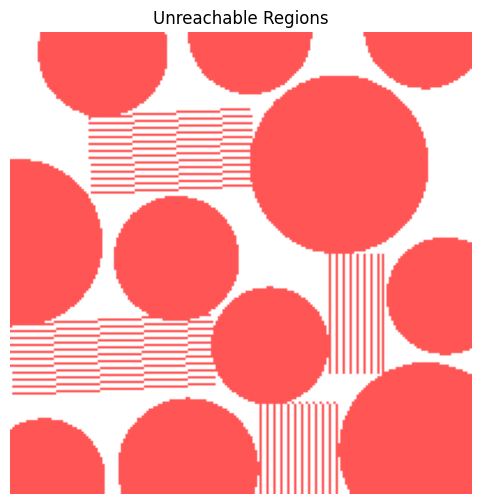

🔴 이온이 도달 불가능한 면적 비율: 0.00%


In [ ]:
# 3색 구분: 0 = 도달 가능 전해질, 1 = 입자, 2 = 도달 불가능 전해질
visual_map = np.zeros_like(final_obstacle_map, dtype=int)

# 입자 (장애물) 영역
visual_map[final_obstacle_map == 1] = 1

# 도달 불가능한 전해질 영역
unreachable_mask = (final_obstacle_map == 0) & np.isinf(time_map)
visual_map[unreachable_mask] = 2

# 색상 맵 정의
from matplotlib.colors import ListedColormap

# 흰색(도달가능), 검정(입자), 빨강(도달불가)
cmap = ListedColormap(["#FFFFFF", "#000000", "#FF5555"])

# 시각화
plt.figure(figsize=(8, 6))
plt.imshow(visual_map, cmap=cmap)
plt.title("Unreachable Regions")
plt.axis("off")
plt.show()

# 도달 불가능한 전해질 비율 계산
total_electrolyte = np.sum(final_obstacle_map == 0)
unreachable_electrolyte = np.sum(unreachable_mask)

if total_electrolyte > 0:
    unreachable_ratio = (unreachable_electrolyte / total_electrolyte) * 100
    print(f"🔴 이온이 도달 불가능한 면적 비율: {unreachable_ratio:.2f}%")
else:
    print("⚠️ 전해질이 존재하지 않습니다.")
